# Part 1: Building an Item-Item Recommender

If you use Netflix, you will notice that there is a section titled "Because you watched Movie X", which provides recommendations for movies based on a recent movie that you've watched. This is a classic example of an item-item recommendation.

We will generate item-item recommendations using a technique called [collaborative filtering](https://en.wikipedia.org/wiki/Collaborative_filtering). Let's get started!

## Step 1: Import the Dependencies

We will be representing our data as a pandas [DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html).

**What is a DataFrame?**

- a two-dimensional Pandas data structure
- columns represent features, rows represent items
- analogous to an Excel spreadsheet or SQL table

In [ ]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Step 2: Load the Data

Let's download a small version of the [MovieLens](https://www.wikiwand.com/en/MovieLens) dataset. You can access it via the zip file url [here](https://grouplens.org/datasets/movielens/), or directly download [here](http://files.grouplens.org/datasets/movielens/ml-latest-small.zip). We're working with data in `ml-latest-small.zip` and will need to add the following files to our local directory:
- ratings.csv
- movies.csv

Let's load in our data and take a peek at the structure.

In [ ]:
ratings = pd.read_csv("ratings.csv")
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
movies = pd.read_csv("movies.csv")
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


## Step 3: Exploratory Data Analysis

In Part 1 of this tutorial series, we will focus on the `ratings` dataset. We'll need `movies` for subsequent sections. `Ratings` contains users' ratings for a given movie. Let's see how many ratings, unique movies, and unique users are in our dataset.

In [ ]:
n_ratings = len(ratings)
n_movies = ratings['movieId'].nunique()
n_users = ratings['userId'].nunique()

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique movieId's: {n_movies}")
print(f"Number of unique users: {n_users}")
print(f"Average number of ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average number of ratings per movie: {round(n_ratings/n_movies, 2)}")

Number of ratings: 100836
Number of unique movieId's: 9724
Number of unique users: 610
Average number of ratings per user: 165.3
Average number of ratings per movie: 10.37


Now, let's take a look at users' rating counts. We can do this using pandas' `groupby()` and `count()` which groups the data by `userId`'s and counts the number of ratings for each userId.

In [ ]:
user_freq = ratings[['userId', 'movieId']].groupby('userId').count().reset_index()
user_freq.columns = ['userId', 'n_ratings']
user_freq.head()

,userId,n_ratings
0,1,232
1,2,29
2,3,39
3,4,216
4,5,44


In [ ]:
print(f"Mean number of ratings for a given user: {user_freq['n_ratings'].mean():.2f}.")

Mean number of ratings for a given user: 165.30.


On average, a user will have rated ~165 movies. Looks like we have some avid movie watchers in our dataset.

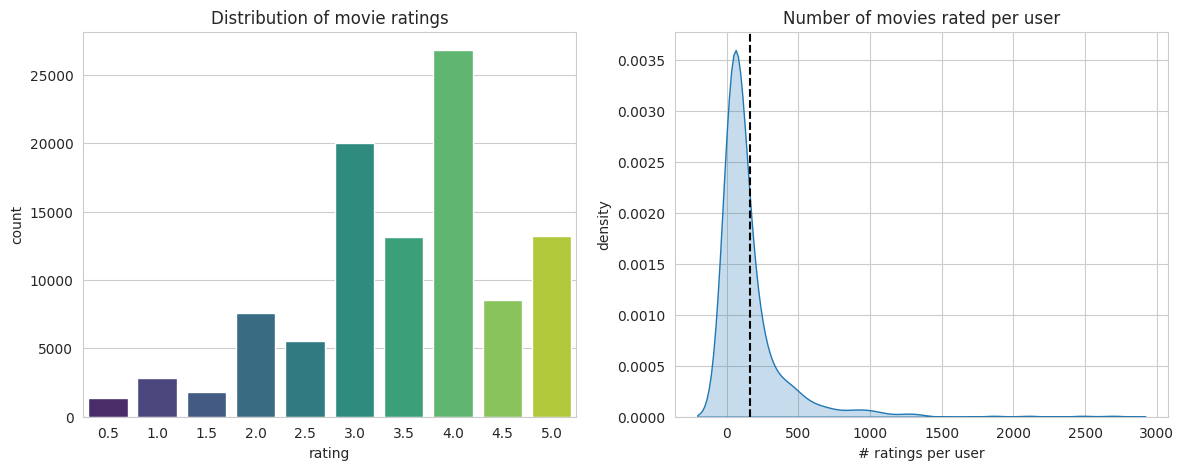

In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
ax = sns.countplot(x="rating", data=ratings, palette="viridis")
plt.title("Distribution of movie ratings")

plt.subplot(1,2,2)
ax = sns.kdeplot(user_freq['n_ratings'], shade=True, legend=False)
plt.axvline(user_freq['n_ratings'].mean(), color="k", linestyle="--")
plt.xlabel("# ratings per user")
plt.ylabel("density")
plt.title("Number of movies rated per user")
plt.show()

The most common rating is 4.0, while lower ratings such as 0.5 or 1.0 are much more rare.

### Which movie has the lowest and highest average rating?

In [ ]:
mean_rating = ratings.groupby('movieId')[['rating']].mean()

lowest_rated = mean_rating['rating'].idxmin()
movies.loc[movies['movieId'] == lowest_rated]

,movieId,title,genres
2689,3604,Gypsy (1962),Musical


In [ ]:
highest_rated = mean_rating['rating'].idxmax()
movies.loc[movies['movieId'] == highest_rated]

,movieId,title,genres
48,53,Lamerica (1994),Adventure|Drama


Lamerica may be the "highest" rated movie, but how many ratings does it have?

In [ ]:
ratings[ratings['movieId']==highest_rated]

,userId,movieId,rating,timestamp
13368,85,53,5.0,889468268
96115,603,53,5.0,963180003


Lamerica has only 2 ratings. A better approach for evaluating movie popularity is to look at the [Bayesian average](https://en.wikipedia.org/wiki/Bayesian_average).

#### Bayesian Average

Bayesian Average is defined as:

$r_{i} = \frac{C \times m + \Sigma{\text{reviews}}}{C+N}$

where $C$ represents our confidence, $m$ represents our prior, and $N$ is the total number of reviews for movie $i$. In this case, our prior will be the average rating across all movies. By defintion, C represents "the typical dataset size". Let's make $C$ be the average number of ratings for a given movie.

In [ ]:
movie_stats = ratings.groupby('movieId')[['rating']].agg(['count', 'mean'])
movie_stats.columns = movie_stats.columns.droplevel()

In [ ]:
C = movie_stats['count'].mean()
m = movie_stats['mean'].mean()

def bayesian_avg(ratings):
    bayesian_avg = (C*m+ratings.sum())/(C+ratings.count())
    return bayesian_avg

bayesian_avg_ratings = ratings.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['movieId', 'bayesian_avg']
movie_stats = movie_stats.merge(bayesian_avg_ratings, on='movieId')

In [ ]:
movie_stats = movie_stats.merge(movies[['movieId', 'title']])
movie_stats.sort_values('bayesian_avg', ascending=False).head()

,movieId,count,mean,bayesian_avg,title
277,318,317,4.429022,4.392070,"Shawshank Redemption, The (1994)"
659,858,192,4.289062,4.236457,"Godfather, The (1972)"
2224,2959,218,4.272936,4.227052,Fight Club (1999)
224,260,251,4.231076,4.192646,Star Wars: Episode IV - A New Hope (1977)
46,50,204,4.237745,4.190567,"Usual Suspects, The (1995)"


Using the Bayesian average, we see that `Shawshank Redemption`, `The Godfather`, and `Fight Club` are the most highly rated movies. This result makes much more sense since these movies are critically acclaimed films.

Now which movies are the worst rated, according to the Bayesian average?

In [ ]:
movie_stats.sort_values('bayesian_avg', ascending=True).head()

,movieId,count,mean,bayesian_avg,title
1172,1556,19,1.605263,2.190377,Speed 2: Cruise Control (1997)
2679,3593,19,1.657895,2.224426,Battlefield Earth (2000)
1372,1882,33,1.954545,2.267268,Godzilla (1998)
1144,1499,27,1.925926,2.296800,Anaconda (1997)
1988,2643,16,1.687500,2.306841,Superman IV: The Quest for Peace (1987)


With Bayesian averaging, it looks like `Speed 2: Cruise Control`, `Battlefield Earth`, and `Godzilla` are the worst rated movies. `Gypsy` isn't so bad after all!

## Step 4: Transforming the data

We will be using a technique called [collaborative filtering](https://en.wikipedia.org/wiki/Collaborative_filtering) to generate user recommendations. This technique is based on the assumption of "homophily" - similar users like similar things. Collaborative filtering is a type of unsupervised learning that makes predictions about the interests of a user by learning from the interests of a larger population.

The first step of collaborative filtering is to transform our data into a `user-item matrix` - also known as a "utility" matrix. In this matrix, rows represent users and columns represent items. The beauty of collaborative filtering is that it doesn't require any information about the users or items to generate recommendations.


<img src="images/user-movie-matrix.png" width="500px" align="left">

The `create_X()` function outputs a sparse matrix X with four mapper dictionaries:
- **user_mapper:** maps user id to user index
- **movie_mapper:** maps movie id to movie index
- **user_inv_mapper:** maps user index to user id
- **movie_inv_mapper:** maps movie index to movie id

We need these dictionaries because they map which row and column of the utility matrix corresponds to which user ID and movie ID, respectively.

The **X** (user-item) matrix is a [scipy.sparse.csr_matrix](scipylinkhere) which stores the data sparsely.

In [ ]:
from scipy.sparse import csr_matrix

def create_X(df):
    """
    Generates a sparse matrix from ratings dataframe.

    Args:
        df: pandas dataframe

    Returns:
        X: sparse matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        movie_mapper: dict that maps movie id's to movie indices
        movie_inv_mapper: dict that maps movie indices to movie id's
    """
    N = df['userId'].nunique()
    M = df['movieId'].nunique()

    user_mapper = dict(zip(np.unique(df["userId"]), list(range(N))))
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(M))))

    user_inv_mapper = dict(zip(list(range(N)), np.unique(df["userId"])))
    movie_inv_mapper = dict(zip(list(range(M)), np.unique(df["movieId"])))

    user_index = [user_mapper[i] for i in df['userId']]
    movie_index = [movie_mapper[i] for i in df['movieId']]

    X = csr_matrix((df["rating"], (movie_index, user_index)), shape=(M, N))

    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

In [ ]:
X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_X(ratings)

Let's check out the sparsity of our X matrix.

Here, we calculate sparsity by dividing the number of non-zero elements by total number of elements as described in the equation below:

$$S=\frac{\text{# non-zero elements}}{\text{total elements}}$$

In [ ]:
sparsity = X.count_nonzero()/(X.shape[0]*X.shape[1])

print(f"Matrix sparsity: {round(sparsity*100,2)}%")

Matrix sparsity: 1.7%


Only 1.7% of cells in our user-item matrix are populated with ratings. But don't be discouraged by this sparsity! User-item matrices are typically very sparse. A general rule of thumb is that your matrix sparsity should be no lower than 0.5% to generate decent results.

### Writing your matrix to a file

We're going to save our user-item matrix for the next part of this tutorial series. Since our matrix is represented as a scipy sparse matrix, we can use the [scipy.sparse.save_npz](https://docs.scipy.org/doc/scipy-1.1.0/reference/generated/scipy.sparse.load_npz.html) method to write the matrix to a file.

In [ ]:
from scipy.sparse import save_npz

save_npz('/content/user_item_matrix.npz', X)

<img src="images/knn.png" width="20%" align="right"/>

## Step 5: Finding similar movies using k-Nearest Neighbours

This approach looks for the $k$ nearest neighbours of a given movie by identifying $k$ points in the dataset that are closest to movie $m$. kNN makes use of distance metrics such as:

1. Cosine similarity
2. Euclidean distance
3. Manhattan distance
4. Pearson correlation

Although difficult to visualize, we are working in a M-dimensional space where M represents the number of movies in our X matrix.

In [ ]:
from sklearn.neighbors import NearestNeighbors

def find_similar_movies(movie_id, X, k, metric='cosine', show_distance=False):
    """
    Finds k-nearest neighbours for a given movie id.

    Args:
        movie_id: id of the movie of interest
        X: user-item utility matrix
        k: number of similar movies to retrieve
        metric: distance metric for kNN calculations

    Returns:
        list of k similar movie ID's
    """
    neighbour_ids = []

    movie_ind = movie_mapper[movie_id]
    movie_vec = X[movie_ind]
    k+=1
    kNN = NearestNeighbors(n_neighbors=k, algorithm="brute", metric=metric)
    kNN.fit(X)
    if isinstance(movie_vec, (np.ndarray)):
        movie_vec = movie_vec.reshape(1,-1)
    neighbour = kNN.kneighbors(movie_vec, return_distance=show_distance)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(movie_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

`find_similar_movies()` takes in a movieId and user-item X matrix, and outputs a list of $k$ movies that are similar to the movieId of interest.

Let's see how it works in action. We will first create another mapper that maps `movieId` to `title` so that our results are interpretable.

In [ ]:
movie_titles = dict(zip(movies['movieId'], movies['title']))

movie_id = 1

similar_ids = find_similar_movies(movie_id, X, k=10)
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}")
for i in similar_ids:
    print(movie_titles[i])

Because you watched Toy Story (1995)
Toy Story 2 (1999)
Jurassic Park (1993)
Independence Day (a.k.a. ID4) (1996)
Star Wars: Episode IV - A New Hope (1977)
Forrest Gump (1994)
Lion King, The (1994)
Star Wars: Episode VI - Return of the Jedi (1983)
Mission: Impossible (1996)
Groundhog Day (1993)
Back to the Future (1985)


The results above show the 10 most similar movies to Toy Story. Most movies in this list are family movies from the 1990s, which seems pretty reasonable. Note that these recommendations are based solely on user-item ratings. Movie features such as genres are not taken into consideration in this approach.  

You can also play around with the kNN distance metric and see what results you would get if you use "manhattan" or "euclidean" instead of "cosine".

**Task:** use a different method (K-Means) to implement a recommender system.

##Step 6. Dimensionality Reduction

Perform dimensionality reduction using and visualize the result.

First, compute the projections.

In [ ]:
from scipy.sparse.linalg import svds

# Merge datasets on movieId
data = ratings.merge(movies, on="movieId")

# Create a user-item matrix
user_item_matrix = data.pivot(index='userId', columns='movieId', values='rating').fillna(0)

# Convert to numpy array for SVD
matrix = user_item_matrix.values

# Compute SVD
U, sigma, Vt = svds(matrix, k=10)  # Reduce to 10 latent features
sigma = np.diag(sigma)

# Project users and items into reduced dimensions
user_projection = np.dot(U, sigma)
item_projection = np.dot(sigma, Vt)

Next, visualize the latent space.

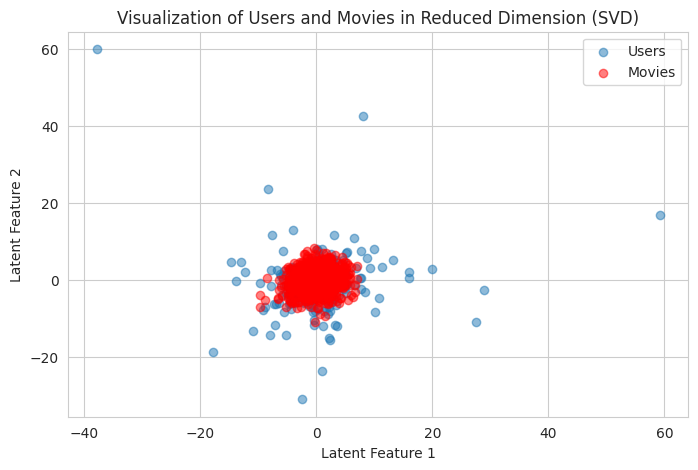

In [ ]:
# Visualization of SVD results
plt.figure(figsize=(8, 5))
plt.scatter(user_projection[:, 0], user_projection[:, 1], alpha=0.5, label="Users")
plt.scatter(item_projection[0, :], item_projection[1, :], alpha=0.5, label="Movies", color='red')
plt.xlabel("Latent Feature 1")
plt.ylabel("Latent Feature 2")
plt.title("Visualization of Users and Movies in Reduced Dimension (SVD)")
plt.legend()
plt.show()

Blue points represent users in the reduced latent space. Red points represent movies in the reduced latent space. This plot allows us to see how closely related users and movies are based on their interactions.

**Task:** Experiment with matrix factorization using another method (Non-Negative Matrix Factorization, NNMF) and compare the result.

Next, create a heatmap visualization of the item-item similarity matrix.

In [ ]:
# Import cosine_similarity function
from sklearn.metrics.pairwise import cosine_similarity

# Select the top 100 most-rated movies
top_movies = ratings['movieId'].value_counts().head(100).index
filtered_user_item_matrix = user_item_matrix[top_movies]

# Compute cosine similarity for the selected subset
filtered_item_similarity = cosine_similarity(filtered_user_item_matrix.T)
filtered_item_similarity_df = pd.DataFrame(filtered_item_similarity, index=top_movies, columns=top_movies)

Plot the heatmap.

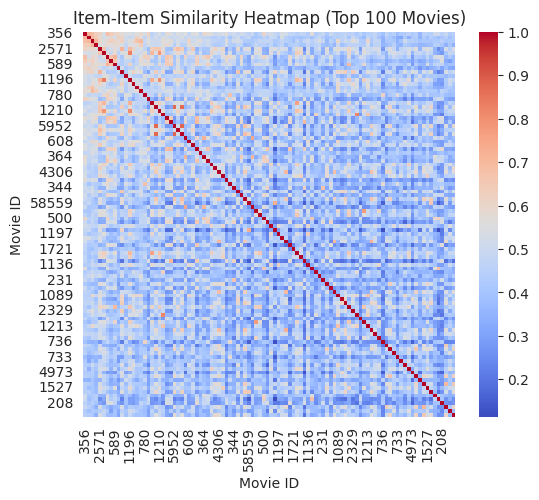

In [ ]:
# Plot the heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(filtered_item_similarity_df, cmap='coolwarm', annot=False)
plt.title("Item-Item Similarity Heatmap (Top 100 Movies)")
plt.xlabel("Movie ID")
plt.ylabel("Movie ID")
plt.show()

Brighter areas indicate higher similarity between movies. Darker areas represent lower similarity. This visualization helps in understanding which movies are closely related based on user interactions.

Next, perform a clustering analysis of similar items and interpret the results.

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Reduce dimensionality before clustering to improve efficiency
pca = PCA(n_components=10)  # Reduce to 10 principal components
item_features_reduced = pca.fit_transform(filtered_item_similarity)

# Perform KMeans clustering
num_clusters = 5  # Set the number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(item_features_reduced)

# Add clustering labels to the DataFrame
clustered_items_df = pd.DataFrame({'MovieID': top_movies, 'Cluster': clusters})

# Visualize clustering using PCA (2D plot)
pca_2d = PCA(n_components=2)
items_2d = pca_2d.fit_transform(item_features_reduced)

Visualize clustering using PCA (2D plot)

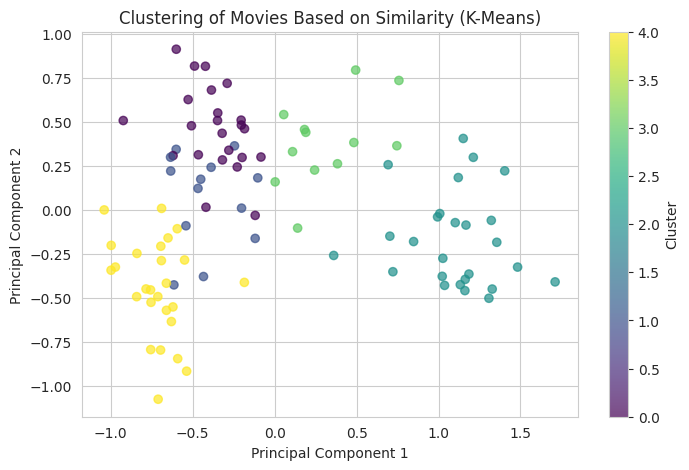

In [ ]:
plt.figure(figsize=(8, 5))
scatter = plt.scatter(items_2d[:, 0], items_2d[:, 1], c=clusters, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label="Cluster")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Clustering of Movies Based on Similarity (K-Means)")
plt.show()

Display clustering results

In [ ]:
# Display clustering results using Pandas for user reference
import pandas as pd

# Show the first few clustered items
clustered_items_df.head(20)

,MovieID,Cluster
0,356,3
1,318,3
2,296,3
3,593,3
4,2571,0
5,260,0
6,480,3
7,110,3
8,589,3
9,527,3


Each movie is assigned to a cluster (0-4) based on similarity. Movies within the same cluster share similar interaction patterns, making them suitable for recommendations together.

##Step 7. Performance Evaluation

Implement precision, recall, and F1-score for evaluating recommendation quality.

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Define a threshold for relevant recommendations (e.g., ratings >= 4.0 are considered "liked" by users)
threshold = 3.0

# Create ground truth labels (1 if rating >= threshold, else 0)
merged_data = ratings.merge(movies, on="movieId")
y_true = (merged_data["rating"] >= threshold).astype(int)

# Generate a baseline prediction (e.g., predicting items with an average rating above the threshold)
average_movie_ratings = merged_data.groupby("movieId")["rating"].mean()
y_pred = merged_data["movieId"].map(lambda x: 1 if average_movie_ratings[x] >= threshold else 0)

# Compute precision, recall, and F1-score
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)

# Create a summary dataframe
evaluation_metrics = {
    "Precision": precision,
    "Recall": recall,
    "F1-Score": f1,
}

evaluation_df = pd.DataFrame(list(evaluation_metrics.items()), columns=["Metric", "Value"])

# Display results
evaluation_df.head(3)

,Metric,Value
0,Precision,0.873907
1,Recall,0.913261
2,F1-Score,0.893151


Calculate Mean Average Precision (MAP) to assess ranking quality.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import average_precision_score

def mean_average_precision(y_true, y_pred_scores, k=10):
    """
    Compute Mean Average Precision (MAP) at K.

    :param y_true: Dictionary of ground truth relevant items per user {userId: set(movieIds)}
    :param y_pred_scores: Dictionary of predicted item scores per user {userId: list of (movieId, score)}
    :param k: Rank position to evaluate MAP
    :return: Mean Average Precision at K
    """
    average_precisions = []

    for user_id in y_true.keys():
        if user_id in y_pred_scores:
            # Get true relevant items for the user
            true_items = y_true[user_id]

            # Get the top-K recommended items sorted by score
            ranked_items = [movie for movie, score in sorted(y_pred_scores[user_id], key=lambda x: x[1], reverse=True)[:k]]

            # Generate binary relevance list for evaluation
            relevance = [1 if item in true_items else 0 for item in ranked_items]

            # Compute Average Precision (AP) for this user
            if sum(relevance) > 0:
                ap = average_precision_score(relevance, list(range(len(relevance), 0, -1)))
                average_precisions.append(ap)

    # Compute Mean Average Precision
    return np.mean(average_precisions) if average_precisions else 0

In [ ]:
# Define threshold for relevant recommendations
threshold = 3.0

# Create ground truth: users and their relevant movieIds (rated >= threshold)
y_true = ratings[ratings["rating"] >= threshold].groupby("userId")["movieId"].apply(set).to_dict()

# Compute average rating per movie as a simple relevance score
average_movie_ratings = ratings.groupby("movieId")["rating"].mean().to_dict()

# Generate predictions: Recommend top movies to each user based on movie average rating
y_pred_scores = ratings.groupby("userId")["movieId"].apply(
    lambda movie_ids: [(movie_id, average_movie_ratings[movie_id]) for movie_id in movie_ids]
).to_dict()

# Compute Mean Average Precision (MAP@10)
map_score = mean_average_precision(y_true, y_pred_scores, k=10)

# Print the result
print(f"MAP@10: {map_score:.4f}")

MAP@10: 0.9695


Calculate NDCG (Normalized Discounted Cumulative Gain) to measure the quality of ranking, considering the relevance of recommended items.

In [ ]:
def dcg_at_k(relevance, k):
    """
    Compute Discounted Cumulative Gain (DCG) at K.

    :param relevance: List of binary relevance scores (1 if relevant, 0 otherwise)
    :param k: Rank position to evaluate DCG
    :return: DCG score
    """
    relevance = np.array(relevance[:k])
    return np.sum(relevance / np.log2(np.arange(2, len(relevance) + 2)))


In [ ]:
def ndcg_at_k(y_true, y_pred_scores, k=10):
    """
    Compute Normalized Discounted Cumulative Gain (NDCG) at K.

    :param y_true: Dictionary of ground truth relevant items per user {userId: set(movieIds)}
    :param y_pred_scores: Dictionary of predicted item scores per user {userId: list of (movieId, score)}
    :param k: Rank position to evaluate NDCG
    :return: Mean NDCG at K
    """
    ndcg_scores = []

    for user_id in y_true.keys():
        if user_id in y_pred_scores:
            true_items = y_true[user_id]

            # Get the top-K recommended items
            ranked_items = [movie for movie, score in sorted(y_pred_scores[user_id], key=lambda x: x[1], reverse=True)[:k]]

            # Generate binary relevance scores
            relevance = [1 if item in true_items else 0 for item in ranked_items]
            ideal_relevance = sorted(relevance, reverse=True)  # Ideal ranking

            # Compute DCG and IDCG
            dcg = dcg_at_k(relevance, k)
            idcg = dcg_at_k(ideal_relevance, k)

            # Compute NDCG
            ndcg_scores.append(dcg / idcg if idcg > 0 else 0)

    return np.mean(ndcg_scores) if ndcg_scores else 0

In [ ]:
# Compute Normalized Discounted Cumulative Gain (NDCG@10)
ndcg_score = ndcg_at_k(y_true, y_pred_scores, k=10)

# Print results
print(f"NDCG@10: {ndcg_score:.4f}")

NDCG@10: 0.9859


##Step 8. Explainability

Write code to explain recommendation.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def explain_recommendation(user_id, movie_id, user_item_matrix, movie_titles, ratings_df):
    """
    Explain why a movie was recommended to a user, including similar users who liked it.

    :param user_id: Target user ID
    :param movie_id: Target movie ID (recommended movie)
    :param user_item_matrix: User-Item rating matrix
    :param movie_titles: Dictionary mapping movieId to movie title
    :param ratings_df: DataFrame of user ratings (userId, movieId, rating)
    :return: Explanation string
    """
    if user_id not in user_item_matrix.index or movie_id not in user_item_matrix.columns:
        return "User or Movie not found in dataset."

    # Compute item-item similarity matrix using cosine similarity
    item_similarity_matrix = cosine_similarity(user_item_matrix.T)
    item_similarity_df = pd.DataFrame(item_similarity_matrix, index=user_item_matrix.columns, columns=user_item_matrix.columns)

    # Find similar movies
    similar_movies = item_similarity_df[movie_id].sort_values(ascending=False)[1:6]  # Top 5 similar movies

    # Get movies the user has rated highly
    user_rated_movies = user_item_matrix.loc[user_id]
    top_rated_movies = user_rated_movies[user_rated_movies >= 4.0].index.tolist()  # Movies rated >=4.0

    # Find similar users who liked this movie
    users_who_liked = ratings_df[(ratings_df["movieId"] == movie_id) & (ratings_df["rating"] >= 4.0)]["userId"].tolist()
    similar_users = ", ".join(map(str, users_who_liked[:5]))  # Show top 5 similar users

    # Construct explanation
    explanation = f"Movie '{movie_titles.get(movie_id, 'Unknown')}' was recommended because:\n"
    explanation += "- It is similar to movies you've rated highly:\n"

    for sim_movie in similar_movies.index:
        if sim_movie in top_rated_movies:
            explanation += f"  * '{movie_titles.get(sim_movie, 'Unknown')}' (Similarity: {similar_movies[sim_movie]:.2f})\n"

    explanation += "- Many users with similar taste also liked this movie.\n"

    if users_who_liked:
        explanation += f"- Other users who also liked this movie: {similar_users}...\n"

    return explanation

In [ ]:
# Example usage
user_id = 1  # Replace with a real userId
recommended_movie_id = 50  # Replace with a real recommended movieId

# Create user-item rating matrix
user_item_matrix = ratings.pivot(index="userId", columns="movieId", values="rating").fillna(0)

# Create a movieId to title mapping
movie_titles = movies.set_index("movieId")["title"].to_dict()

# Generate explanation
explanation_text = explain_recommendation(user_id, recommended_movie_id, user_item_matrix, movie_titles, ratings)

# Print explanation
print(explanation_text)


Movie 'Usual Suspects, The (1995)' was recommended because:
- It is similar to movies you've rated highly:
  * 'Reservoir Dogs (1992)' (Similarity: 0.60)
  * 'Goodfellas (1990)' (Similarity: 0.58)
  * 'Seven (a.k.a. Se7en) (1995)' (Similarity: 0.58)
- Many users with similar taste also liked this movie.
- Other users who liked this movie: 1, 5, 7, 8, 16...

